In [56]:
%pip install pydantic[email]


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [57]:
%pip install phonenumbers


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [58]:
%pip install pydantic-extra-types


[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


### Necessory Libraries

In [59]:
from typing import TypedDict, List, Optional, Union
from langgraph.prebuilt import create_react_agent
from pydantic import BaseModel, Field,EmailStr,field_validator
from langchain.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain.prompts import MessagesPlaceholder
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage,BaseMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from pydantic_extra_types.phone_numbers import PhoneNumber
from langgraph.graph import StateGraph,add_messages,START,END
from langchain_core.agents import AgentAction,AgentFinish

In [60]:
from langgraph.prebuilt import ToolNode

In [61]:
from dotenv import load_dotenv
load_dotenv()

True

In [ ]:
llm = ChatGoogleGenerativeAI(model = "gemini-2.0-flash-001", temperature=0)

In [63]:
class UserData(BaseModel):
    """Necessary user data for the agent."""
    name: str = Field(..., description="The name of the user")
    age: int = Field(..., description="The age of the user")
    gender: str = Field(..., description="The gender of the user")
    address: str = Field(..., description="The address of the user")
    email: EmailStr = Field(..., description="The email of the user")
    phone_number: PhoneNumber = Field(..., description="The phone number of the user")

    @field_validator("phone_number", mode="before")
    def preprocess_phone(cls, phone: str) -> str:
        """Ensures phone number includes country code if missing."""
        if phone.isdigit() and len(phone) == 10:
            phone = "+91" + phone  # Append country code
        return phone

In [64]:
class UserData1(TypedDict):
    """Necessary user data for the agent."""
    name: str
    age: int
    gender: str
    address: str
    email: str
    phone_number: int

In [65]:
validator_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content="You are a data validation agent. Your task is to validate user data based on the provided schema. you will receive the user input , the user input will be in the string format, and you need to extract the relevant fields from it.and validate them against the schema. If the data is valid, return a message indicating that the data is valid. If the data is invalid, return a message indicating which fields are invalid and why.also return the field names which are not available,"      
        ),
        AIMessage(
            content="Please provide a response in the format: {'valid': True/False, 'message': 'Your message here'}"
        ),
        MessagesPlaceholder(variable_name="user_input"),
        ("system","from the given user input, extract the following fields: name, age, gender, location, email, phone number and return in the dictionary format, if any field is not available in the user input, return it as None. The user input will be in the string format, and you need to extract the relevant fields from it. If the data is valid, return a message indicating that the data is valid. If the data is invalid, return a message indicating which fields are invalid and why.also return the field names which are not available. The output should be in the following format: \n"
        " 'name': 'name of patient', 'age': 'age of patient',  'gender': 'gender of patient', 'location': 'location of patient', 'email': 'email of patient', 'phone number': 'phone number of patient'")     

    ]
)


In [66]:
data_collection_prompt = ChatPromptTemplate.from_messages(
    [
        SystemMessage(
            content="You are a data collection agent. Your task is to collect user data based on the provided schema. You will receive the user input, and you need check weather all the fields are present in the user input or not. If any field is not present, you need to ask the user for that field. If all the fields are present, you need to return True.else return False and the field names which are not available. The user input will be in the string format,"
        ),
        MessagesPlaceholder(variable_name="user_input"),
        ("system","from the given user input, extract the following fields: name, age, gender, location, email, phone number if any field is not available in the user input, return it as None."
        "The fields are:name,age,gender,address,email,phonenumber")

    ]
)


In [67]:
data_chain = data_collection_prompt | llm

In [68]:
chain = validator_prompt | llm.with_structured_output(UserData)

In [69]:
res = chain.invoke({"user_input": ["hi my name is kiran,i am 20 years old,i live in mumbai,  and my phone number is 1234567890"]})

In [70]:
res1 = data_chain.invoke({"user_input": ["hi my name is kiran,i am 20 years old,i live in mumbai,  and my phone number is 1234567890"]})

In [71]:
print(res)

name='kiran' age=20 gender='male' address='mumbai' email='example@example.com' phone_number='tel:+91-1234-567-890'


In [72]:
from pprint import pprint

pprint(res1)

AIMessage(content='Okay, I need a bit more information to complete your profile. I have the following:\n\n*   **name:** kiran\n*   **age:** 20\n*   **address:** mumbai\n*   **phonenumber:** 1234567890\n\nI am missing:\n\n*   **gender**\n*   **email**\n\nCould you please provide me with your gender and email?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash-001', 'safety_ratings': []}, id='run--9ee34dce-c70d-44f4-aa64-35906f538781-0', usage_metadata={'input_tokens': 188, 'output_tokens': 90, 'total_tokens': 278, 'input_token_details': {'cache_read': 0}})


#### sql database for scheduling

In [73]:
import sqlite3
slot_conn = sqlite3.connect("slot_status.db")
slot_cursor = slot_conn.cursor()

In [74]:
import sqlite3
from datetime import datetime, timedelta

# Connect to SQLite database
slot_conn = sqlite3.connect("slot_status.db")
slot_cursor = slot_conn.cursor()

# Drop old table
slot_cursor.execute('DROP TABLE IF EXISTS slots')

# Create new table with `date` column
slot_cursor.execute('''
    CREATE TABLE IF NOT EXISTS slots (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        slot TEXT NOT NULL,
        status INTEGER NOT NULL,
        date TEXT NOT NULL
    )
''')
slot_conn.commit()





In [75]:
@tool
def view_available_slots() -> List:
    """Lists todays available slots"""
    available_slots = []
    today = datetime.today().date().isoformat()
    slot_cursor.execute('SELECT id, slot FROM slots WHERE status = 0 AND date = ?', (today,))
    slots = slot_cursor.fetchall()
    if not slots:
        print("❌ No available slots for today.")
        return available_slots
    else:
        print(f"📅 Available slots for {today}:")
        for slot in slots:
            print(f"ID: {slot[0]} | Time: {slot[1]}")
            available_slots.append(slot)
        return available_slots



In [76]:
@tool
def book_slot(slot_id):
    """Books available slot on today using slot_id """
    today = datetime.today().date().isoformat()
    # Check if the slot is free
    slot_cursor.execute('SELECT status FROM slots WHERE id = ? AND date = ?', (slot_id, today))
    row = slot_cursor.fetchone()
    if row is None:
        print(f"❌ Slot ID {slot_id} is invalid for today.")
    elif row[0] == 1:
        print(f"⚠️ Slot ID {slot_id} is already booked.")
    else:
        slot_cursor.execute('UPDATE slots SET status = 1 WHERE id = ? AND date = ?', (slot_id, today))
        slot_conn.commit()
        print(f"✅ Slot ID {slot_id} booked successfully.")

In [77]:
def create_slot(slot, status, date):
    slot_cursor.execute('INSERT INTO slots (slot, status, date) VALUES (?, ?, ?)', (slot, status, date))
    slot_conn.commit()
    print(f"✅ Slot '{slot}' created for {date} with status {status}")

In [112]:
def generate_daily_slots():
    today = datetime.today().date().isoformat()

    # Check if today's slots are already created
    slot_cursor.execute('SELECT COUNT(*) FROM slots WHERE date = ?', (today,))
    if slot_cursor.fetchone()[0] > 0:
        print(f"🟢 Slots for {today} already exist.")
        return

    # Generate 20-minute slots from 9:00 AM to 5:00 PM
    print(f"🛠️ Generating slots for {today}...")
    start_time = datetime.strptime("09:00", "%H:%M")
    end_time = datetime.strptime("17:00", "%H:%M")
    duration = timedelta(minutes=20)

    while start_time < end_time:
        slot_label = f"{start_time.strftime('%I:%M %p')} - {(start_time + duration).strftime('%I:%M %p')}"
        create_slot(slot_label, 0, today)
        start_time += duration

    print("✅ Daily slot generation complete.")

In [116]:
if __name__ == "__main__":
    # Generate today's slots (run once per day)
    generate_daily_slots()

    # Show free slots
    view_available_slots({})

    # Book a slot (user input example)
    try:
        slot_id = input("Enter the slot ID to book: ")
        book_slot(slot_id)
    except ValueError:
        print("❌ Invalid input. Please enter a number.")


🟢 Slots for 2025-06-12 already exist.
📅 Available slots for 2025-06-12:
ID: 25 | Time: 09:00 AM - 09:20 AM
ID: 26 | Time: 09:20 AM - 09:40 AM
ID: 27 | Time: 09:40 AM - 10:00 AM
ID: 28 | Time: 10:00 AM - 10:20 AM
ID: 29 | Time: 10:20 AM - 10:40 AM
ID: 30 | Time: 10:40 AM - 11:00 AM
ID: 31 | Time: 11:00 AM - 11:20 AM
ID: 32 | Time: 11:20 AM - 11:40 AM
ID: 33 | Time: 11:40 AM - 12:00 PM
ID: 34 | Time: 12:00 PM - 12:20 PM
ID: 35 | Time: 12:20 PM - 12:40 PM
ID: 36 | Time: 12:40 PM - 01:00 PM
ID: 37 | Time: 01:00 PM - 01:20 PM
ID: 38 | Time: 01:20 PM - 01:40 PM
ID: 39 | Time: 01:40 PM - 02:00 PM
ID: 40 | Time: 02:00 PM - 02:20 PM
ID: 41 | Time: 02:20 PM - 02:40 PM
ID: 42 | Time: 02:40 PM - 03:00 PM
ID: 43 | Time: 03:00 PM - 03:20 PM
ID: 44 | Time: 03:20 PM - 03:40 PM
ID: 45 | Time: 03:40 PM - 04:00 PM
ID: 46 | Time: 04:00 PM - 04:20 PM
ID: 47 | Time: 04:20 PM - 04:40 PM
ID: 48 | Time: 04:40 PM - 05:00 PM
✅ Slot ID 41 booked successfully.


#### state schema

In [80]:
from ast import Dict
from typing import Annotated


class AgentState(TypedDict):
    messages: Annotated[List[BaseMessage],add_messages]
    data: Dict  

#### scheduling agent tools

In [81]:
print(type(view_available_slots))

<class 'langchain_core.tools.structured.StructuredTool'>


In [82]:
from dis import show_code


list_available_slots = ToolNode([view_available_slots])
book_available_slot = ToolNode([book_slot])

In [83]:
scheduler_tools= [ list_available_slots,book_available_slot]

#### scheduing Agent

In [84]:
from urllib import response


def scheduler(state:AgentState)-> AgentState:
    
    prompt = ChatPromptTemplate.from_messages(
        [
            SystemMessage(content = "You are appointment scheduling agent for the patient.you shedule the appointment for medical consultation of patient,you schedule appointment from available ,"),
            MessagesPlaceholder(variable_name="user_input"),
        ]
    )
    chain = prompt  | llm
    response =  chain.invoke({"user_input": state['messages']})

    return {"messages": state['messages'] + [AIMessage(content=response.content)], "data": state.get("data", {})}

In [96]:
graph1 = StateGraph(AgentState)

graph1.add_node("scheduler", scheduler)
graph1.add_node("list_available_slots", list_available_slots)
graph1.add_node("book_slot", book_available_slot)

graph1.add_edge("scheduler", "list_available_slots")
graph1.add_edge( "list_available_slots","scheduler")
graph1.add_edge("scheduler","book_slot")
graph1.add_edge("book_slot","scheduler")
graph1.add_edge("scheduler",END)


graph1.set_entry_point("scheduler")
graph1.set_finish_point("scheduler")


app = graph1.compile()

In [97]:
from IPython.display import Image

In [100]:
%pip install grandalf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00
  Using cached pyparsing-3.2.3-py3-none-any.whl (111 kB)

[notice] A new release of pip is available: 23.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [101]:
print(app.get_graph().draw_ascii())

                +-----------+                       
                | __start__ |                       
                +-----------+                       
                      *                             
                      *                             
                      *                             
                +-----------+                       
                | scheduler |                       
                +-----------+                       
              **             ***                    
           ***                  **                  
         **                       **                
+-----------+             +----------------------+  
| book_slot |             | list_available_slots |  
+-----------+             +----------------------+  


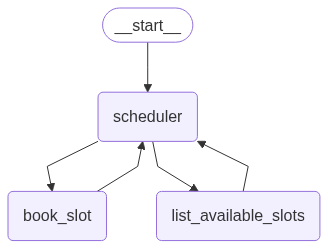

In [98]:
display(Image(app.get_graph().draw_mermaid_png()))

In [105]:
x = app.stream({"user_input":[HumanMessage(content="I want to book an appointment for today")]})



In [110]:
res = list(x)

In [111]:
print(res)

[]


In [109]:
for chunk in x :
     print(x)

#### case generation agent

#### medicin inventory agent